# 日本のCOVID19感染者数分析(情報提供:NHK)

In [1]:
import pandas as pd

In [2]:
pref = pd.read_csv("COVID-19-jp/nhk_news_covid19_prefectures_daily_data.csv")

In [3]:
pref["日付"] = pd.to_datetime(pref["日付"] )

In [4]:
latest_date_str = pref["日付"].max().strftime("%Y/%m/%d")

In [5]:
all_jp = pref.copy().groupby(["日付"], as_index=False).sum()
del all_jp["都道府県コード"]
del all_jp["各地の感染者数_累計"]
del all_jp["各地の死者数_累計"]

In [6]:
all_jp["weekday"] = all_jp["日付"].dt.weekday
weekdays = pd.DataFrame({"曜日":["月","火","水","木","金","土","日"]})
all_jp = pd.merge(all_jp, weekdays, left_on="weekday", right_index=True, how="left")

## 移動平均

In [7]:
all_jp["感染者数移動平均7"] = all_jp["各地の感染者数_1日ごとの発表数"].rolling(7).mean()
all_jp["死者数移動平均7"] = all_jp["各地の死者数_1日ごとの発表数"].rolling(7).mean()
all_jp.tail()

,日付,各地の感染者数_1日ごとの発表数,各地の死者数_1日ごとの発表数,各地の直近1週間の人口10万人あたりの感染者数,weekday,曜日,感染者数移動平均7,死者数移動平均7
686,2021-12-02,114,1,18.38,3,木,103.142857,1.142857
687,2021-12-03,140,1,20.24,4,金,107.000000,1.000000
688,2021-12-04,120,0,20.36,5,土,107.000000,0.857143
689,2021-12-05,104,0,22.36,6,日,113.142857,0.857143
690,2021-12-06,55,1,22.29,0,月,110.285714,0.857143


## 増減速度

In [8]:
all_jp["感染者数移動平均7増減"] = all_jp["感染者数移動平均7"].diff()
all_jp["死者数移動平均7増減"] = all_jp["死者数移動平均7"].diff()
all_jp.tail(7)

,日付,各地の感染者数_1日ごとの発表数,各地の死者数_1日ごとの発表数,各地の直近1週間の人口10万人あたりの感染者数,weekday,曜日,感染者数移動平均7,死者数移動平均7,感染者数移動平均7増減,死者数移動平均7増減
684,2021-11-30,123,2,15.63,1,火,96.285714,1.428571,2.000000,0.000000
685,2021-12-01,116,1,16.99,2,水,102.714286,1.285714,6.428571,-0.142857
686,2021-12-02,114,1,18.38,3,木,103.142857,1.142857,0.428571,-0.142857
687,2021-12-03,140,1,20.24,4,金,107.000000,1.000000,3.857143,-0.142857
688,2021-12-04,120,0,20.36,5,土,107.000000,0.857143,0.000000,-0.142857
689,2021-12-05,104,0,22.36,6,日,113.142857,0.857143,6.142857,0.000000
690,2021-12-06,55,1,22.29,0,月,110.285714,0.857143,-2.857143,0.000000


### 感染者数前週同曜日比

In [9]:
import datetime
all_jp["新規感染者数先週比"] = all_jp["各地の感染者数_1日ごとの発表数"].pct_change(periods=7)
all_jp["死者数先週比"] = all_jp["各地の死者数_1日ごとの発表数"].pct_change(periods=7)
all_jp["新規感染者数先週差"] = all_jp["各地の感染者数_1日ごとの発表数"].diff(periods=7)
all_jp["死者数先週差"] = all_jp["各地の死者数_1日ごとの発表数"].diff(periods=7)


## 都道府県別

In [10]:
pref["感染者数移動平均7"] = pref["各地の感染者数_1日ごとの発表数"].rolling(7).mean()

### 人口あたり

In [11]:
pop = pd.read_excel("COVID-19-jp/2001stjin.xls",header=3)[["Unnamed: 1","計"]]
pop.rename(columns={"Unnamed: 1":"都道府県名"},inplace=True)
pop.rename(columns={"計":"人口"},inplace=True)
pop = pop.loc[pop["都道府県名"]!="合計"].reset_index(drop=True)
pref = pd.merge(pref, pop, on="都道府県名", how="left")

In [12]:
pref["10万人あたり感染者数"] = pref["各地の感染者数_1日ごとの発表数"]/(pref["人口"]/100000)
pref["10万人あたり感染者数移動平均7"] = pref["10万人あたり感染者数"].rolling(7).mean()
pref["10万人あたり感染者数1週間合計"] = pref["10万人あたり感染者数"].rolling(7).sum()

### 感染者数前日比

In [13]:
import numpy as np
pref["感染者数前日比"] = pref["各地の感染者数_1日ごとの発表数"].pct_change()
pref["感染者数前日差"] = pref["各地の感染者数_1日ごとの発表数"].diff()
# 一番古い日付だけNANを設定
pref.loc[pref["日付"]==pref["日付"].min(),"感染者数前日比"] = np.nan
pref["感染者数前日比移動平均7"] = pref["感染者数前日比"].rolling(7).mean()
pref["10万人あたり感染者数移動平均7前日差"] = pref["10万人あたり感染者数移動平均7"].diff()
pref["感染者数移動平均7前日差"] = pref["感染者数移動平均7"].diff()

### 感染者数前週同曜日比

In [14]:
import datetime
# 一番古い日付から一週間分NANを設定
pref["新規感染者数先週比"] = pref["各地の感染者数_1日ごとの発表数"].pct_change(periods=7)
pref["新規感染者数先週差"] = pref["各地の感染者数_1日ごとの発表数"].diff(periods=7)
pref.loc[(pref["日付"] < pref["日付"].min()+datetime.timedelta(days=7)),"新規感染者数先週比"] = np.nan
pref.loc[(pref["日付"] < pref["日付"].min()+datetime.timedelta(days=7)),"新規感染者数先週差"] = np.nan


## 重症者数

In [15]:
severe = pd.read_csv("COVID-19-jp/severe_cases_daily.csv")
severe["Date"] = pd.to_datetime(severe["Date"])
#severe = severe[severe.Prefecture=="ALL"]
severe = severe[["Date","ALL"]].rename(columns={"ALL":"Severe cases"})

severe.tail()

,Date,Severe cases
572,2021-12-02,32
573,2021-12-03,28
574,2021-12-04,29
575,2021-12-05,29
576,2021-12-06,28


In [16]:
print(severe.count())
print(all_jp.count())

Date            577
Severe cases    577
dtype: int64
日付                         691
各地の感染者数_1日ごとの発表数           691
各地の死者数_1日ごとの発表数            691
各地の直近1週間の人口10万人あたりの感染者数    691
weekday                    691
曜日                         691
感染者数移動平均7                  685
死者数移動平均7                   685
感染者数移動平均7増減                684
死者数移動平均7増減                 684
新規感染者数先週比                  679
死者数先週比                     636
新規感染者数先週差                  684
死者数先週差                     684
dtype: int64


## 曜日別陽性者集計

In [17]:
all_jp_week_mean = all_jp.groupby(["weekday"],as_index=False).mean()[["各地の感染者数_1日ごとの発表数","各地の死者数_1日ごとの発表数"]].sort_index()
all_jp_week_mean = pd.merge(all_jp_week_mean, weekdays, left_index=True, right_index=True, how="left")
all_jp_week_mean

,各地の感染者数_1日ごとの発表数,各地の死者数_1日ごとの発表数,曜日
0,1724.313131,23.696970,月
1,2317.959184,32.010204,火
2,2760.132653,31.132653,水
3,2824.151515,28.757576,木
4,2738.353535,29.666667,金
5,2761.040404,23.757576,土
6,2327.484848,17.040404,日


In [18]:
import matplotlib.pyplot as plt
%matplotlib notebook
#%matplotlib inline

Duplicate key in file PosixPath('/home/masaru/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family:  Noto Sans CJK JP')


<IPython.core.display.Javascript object>


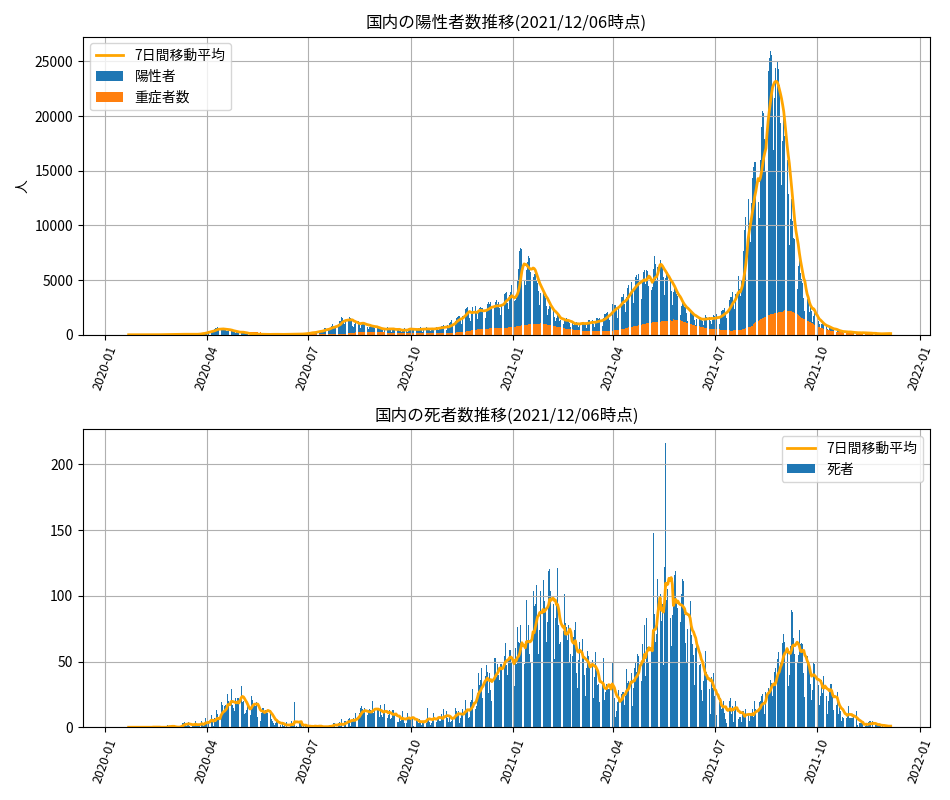

In [19]:
fig=plt.figure(figsize=(9.5,8))
plt.subplot(2,1,1) # (rows, columns, panel number)
plt.title("国内の陽性者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp["日付"],all_jp["各地の感染者数_1日ごとの発表数"],label="陽性者")
plt.bar(severe["Date"],severe["Severe cases"],label="重症者数")
plt.plot_date(all_jp["日付"],all_jp["感染者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
plt.tick_params(axis="x",rotation=70, labelsize=9)
plt.ylabel("人")
plt.grid()
plt.legend()

plt.subplot(2,1,2) # (rows, columns, panel number)
plt.title("国内の死者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp["日付"],all_jp["各地の死者数_1日ごとの発表数"],label="死者")
plt.plot_date(all_jp["日付"],all_jp["死者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
plt.tick_params(axis="x",rotation=70, labelsize=9)
plt.grid()
plt.legend()

fig.tight_layout()


<IPython.core.display.Javascript object>


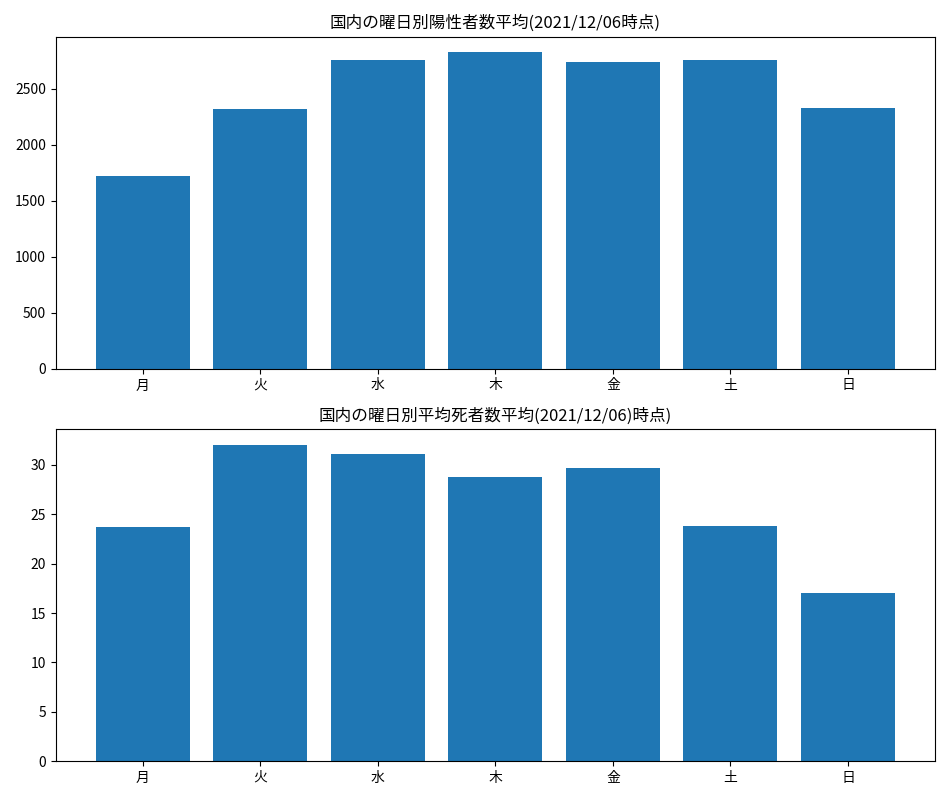

<BarContainer object of 7 artists>

In [20]:
fig=plt.figure(figsize=(9.5,8),tight_layout=True)
plt.subplot(2,1,1) # (rows, columns, panel number)
#fig, ax = plt.subplots(2,1,figsize=(9,8),tight_layout=True)
#wp_ax = ax[0]
plt.title("国内の曜日別陽性者数平均({}時点)".format(latest_date_str))
plt.bar(all_jp_week_mean["曜日"],all_jp_week_mean["各地の感染者数_1日ごとの発表数"])
#wd_ax = ax[1]
plt.subplot(2,1,2) # (rows, columns, panel number)
plt.title("国内の曜日別平均死者数平均({})時点)".format(latest_date_str))
plt.bar(all_jp_week_mean["曜日"],all_jp_week_mean["各地の死者数_1日ごとの発表数"])

## 直近の推移

In [21]:
recent_date = pd.to_datetime(datetime.datetime.now()).round("D")- datetime.timedelta(days=90)
all_jp_recent = all_jp.loc[all_jp["日付"]>=recent_date]
all_jp_recent.tail(30)

,日付,各地の感染者数_1日ごとの発表数,各地の死者数_1日ごとの発表数,各地の直近1週間の人口10万人あたりの感染者数,weekday,曜日,感染者数移動平均7,死者数移動平均7,感染者数移動平均7増減,死者数移動平均7増減,新規感染者数先週比,死者数先週比,新規感染者数先週差,死者数先週差
661,2021-11-07,156,0,39.16,6,日,184.428571,6.000000,-8.142857,-1.000000,-0.267606,-1.000000,-57.0,-7.0
662,2021-11-08,102,3,38.84,0,月,187.857143,5.428571,3.428571,-0.571429,0.307692,-0.571429,24.0,-4.0
663,2021-11-09,194,3,37.17,1,火,185.428571,4.857143,-2.428571,-0.571429,-0.080569,-0.571429,-17.0,-4.0
664,2021-11-10,194,3,35.79,2,水,177.142857,4.142857,-8.285714,-0.714286,-0.230159,-0.625000,-58.0,-5.0
665,2021-11-11,208,4,37.03,3,木,186.285714,3.857143,9.142857,-0.285714,0.444444,-0.333333,64.0,-2.0
666,2021-11-12,194,1,34.91,4,金,182.857143,2.285714,-3.428571,-1.571429,-0.110092,-0.916667,-24.0,-11.0
667,2021-11-13,195,1,33.00,5,土,177.571429,2.142857,-5.285714,-0.142857,-0.159483,-0.500000,-37.0,-1.0
668,2021-11-14,124,2,31.24,6,日,173.000000,2.428571,-4.571429,0.285714,-0.205128,inf,-32.0,2.0
669,2021-11-15,74,1,30.02,0,月,169.000000,2.142857,-4.000000,-0.285714,-0.274510,-0.666667,-28.0,-2.0
670,2021-11-16,147,4,27.89,1,火,162.285714,2.285714,-6.714286,0.142857,-0.242268,0.333333,-47.0,1.0


In [22]:
severe_recent = severe.loc[severe["Date"]>=recent_date]
severe_recent.tail(30)

,Date,Severe cases
547,2021-11-07,101
548,2021-11-08,99
549,2021-11-09,96
550,2021-11-10,92
551,2021-11-11,87
552,2021-11-12,83
553,2021-11-13,85
554,2021-11-14,85
555,2021-11-15,82
556,2021-11-16,78


<IPython.core.display.Javascript object>


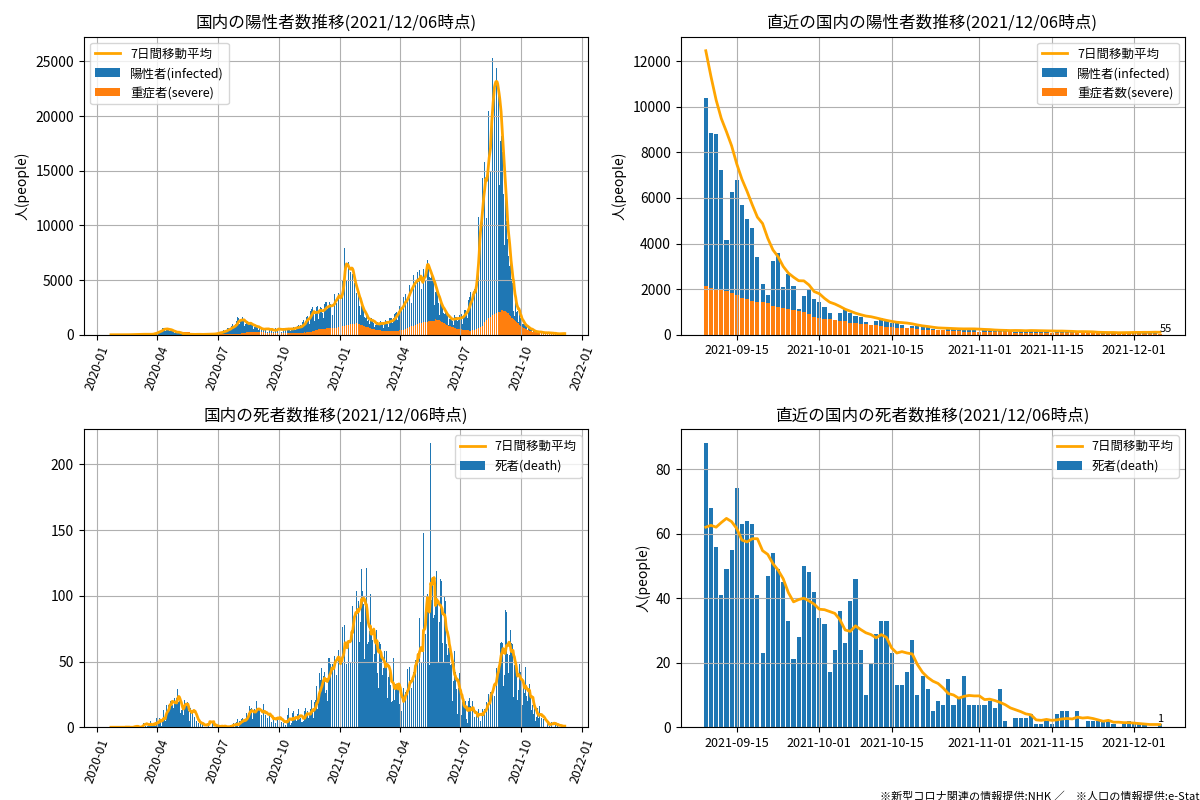

In [23]:
fig=plt.figure(figsize=(12,8))
plt.subplot(2,2,1) # (rows, columns, panel number)
plt.title("国内の陽性者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp["日付"],all_jp["各地の感染者数_1日ごとの発表数"],label="陽性者(infected)")
plt.bar(severe["Date"],severe["Severe cases"],label="重症者(severe)")
plt.plot_date(all_jp["日付"],all_jp["感染者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
plt.tick_params(axis="x",rotation=70, labelsize=9)
plt.ylabel("人(people)")
plt.grid()
plt.legend(fontsize=9)

plt.subplot(2,2,3) # (rows, columns, panel number)
plt.title("国内の死者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp["日付"],all_jp["各地の死者数_1日ごとの発表数"],label="死者(death)")
plt.plot_date(all_jp["日付"],all_jp["死者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
plt.tick_params(axis="x",rotation=70, labelsize=9)
plt.grid()
plt.legend(fontsize=9)

plt.subplot(2,2,2) # (rows, columns, panel number)
plt.title("直近の国内の陽性者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp_recent["日付"],all_jp_recent["各地の感染者数_1日ごとの発表数"],label="陽性者(infected)")
plt.bar(severe_recent["Date"],severe_recent["Severe cases"],label="重症者数(severe)")
plt.plot_date(all_jp_recent["日付"],all_jp_recent["感染者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
#plt.plot_date(all_jp_latest["日付"],all_jp_latest["直近１週間の新規感染者数合計"]/10,label="直近１週間の合計(10人)", fmt="-",lw=2.0, color="m")
plt.tick_params(axis="x",labelsize=9)
plt.ylabel("人(people)")
plt.grid()
latest_date = all_jp_recent["日付"].max()
latest_value = all_jp_recent.loc[all_jp_recent["日付"]==latest_date,"各地の感染者数_1日ごとの発表数"].iloc[0]
plt.text(latest_date,latest_value ,"{:,}".format(latest_value),fontsize=8,va="bottom")
#latest_value = severe_recent.loc[severe_recent["Date"]==latest_date,"Severe cases"].iloc[0]
#plt.text(latest_date,latest_value ,"{:,}".format(latest_value),fontsize=8,va="bottom",ha="left")
plt.legend(fontsize=9)

plt.subplot(2,2,4) # (rows, columns, panel number)
plt.title("直近の国内の死者数推移({}時点)".format(latest_date_str))
plt.bar(all_jp_recent["日付"],all_jp_recent["各地の死者数_1日ごとの発表数"],label="死者(death)")
plt.plot_date(all_jp_recent["日付"],all_jp_recent["死者数移動平均7"],label="7日間移動平均", fmt="-",lw=2.0, color="orange")
plt.tick_params(axis="x", labelsize=9)
plt.ylabel("人(people)")
plt.grid()
latest_value = all_jp_recent.loc[all_jp_recent["日付"]==latest_date,"各地の死者数_1日ごとの発表数"].iloc[0]
plt.text(latest_date,latest_value ,"{:,}".format(latest_value),fontsize=8,va="bottom",ha="center")
plt.legend(fontsize=9)

fig.text(1,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=8,ha="right")

fig.tight_layout()

In [24]:
fig.savefig("out/covid-nhk-domestic-daily.png")

### 都道府県別

In [25]:
prefs = {
    "東京都": ("-",1.1,""),
#    "沖縄県": ("-",1.1,""),
    "埼玉県": ("-",1.1,""),
    "千葉県": ("-",1.1,""),
    "神奈川県": ("-",1.1,""),
#    "栃木県": ("-",1.1,""),
#    "茨城県": ("-",1.1,""),
#    "群馬県": ("-",1.1,""),
#    "静岡県": ("-",1.1,""),
    "京都府": ("-",1.1,""),
    "大阪府": ("-",1.1,""),
    "兵庫県": ("-",1.1,""),
#    "福岡県": ("-",1.1,""),
#    "北海道": ("--",1.0,"2021-05-25"),
#    "石川県": ("--",1.0,""),
#    "福島県": ("--",1.0,""),
#    "愛知県": ("--",1.0,"2021-05-25"),
#    "滋賀県": ("--",1.0,""),
#    "熊本県": ("--",1.0,""),
#    "広島県": ("--",1.0,"2021-04-15"),
#    "岐阜県": ("--",1.0,"2021-05-16"),
#    "三重県": ("--",1.0,"2021-05-27"),
#    "山梨県": (":",1.0,""),
#    "佐賀県": (":",1.5,""),
#    "奈良県": (":",1.5,""),
#    "山口県": (":",1.5,""),
#    "高知県": (":",1.5,""),
#    "青森県": (":",1.5,""),
#    "富山県": (":",1.5,""),
#    "岩手県": (":",1.5,""),
#    "島根県": (":",1.5,""),
}

In [26]:
pref_recent = pref.loc[pref["日付"]>=recent_date]

<IPython.core.display.Javascript object>


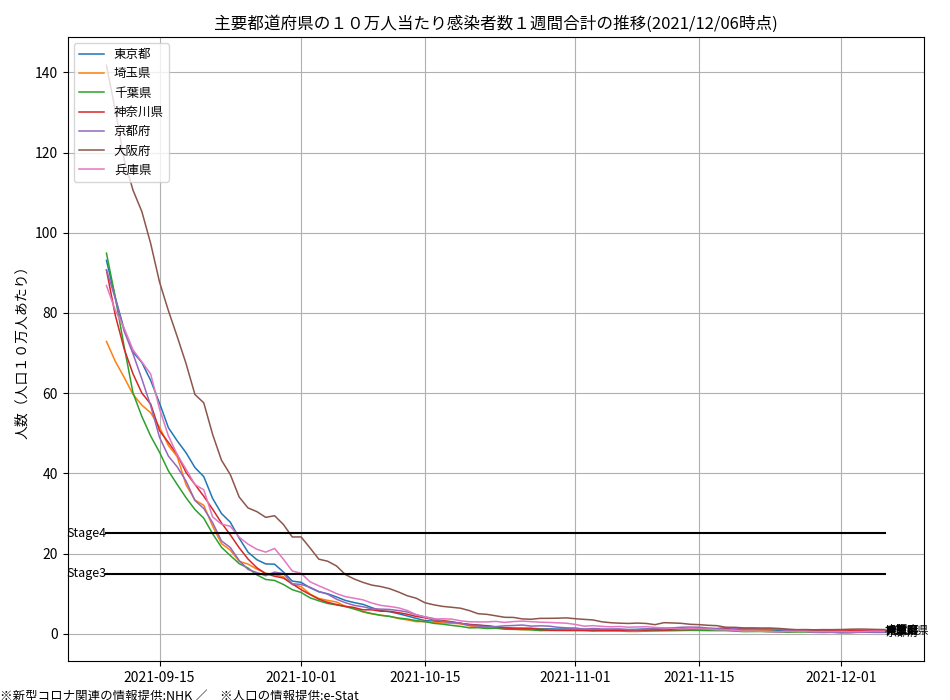

In [27]:
fig = plt.figure(figsize=(9.5,7))
plt.title("主要都道府県の１０万人当たり感染者数１週間合計の推移({}時点)".format(latest_date_str))
dates = pref_recent["日付"].unique()
for p in prefs:
    values = pref_recent.loc[pref_recent["都道府県名"]==p]["10万人あたり感染者数1週間合計"]
    plt.plot_date(dates,values,label=p, fmt=prefs[p][0], lw=prefs[p][1])
    if prefs[p][2] == "":
        text_date = dates.max()
    else:
        text_date = pd.to_datetime(prefs[p][2])
    text_y = pref_recent.loc[(pref_recent["都道府県名"]==p) & (pref_recent["日付"]==text_date)]["10万人あたり感染者数1週間合計"]
    plt.text(text_date,text_y,p,fontsize=8,va="center")
plt.plot([dates.min(),dates.max()],[15,15],"-",lw=1.5,color="black")
plt.text(dates.min(),15,"Stage3",ha="right",va="center",fontsize=9)
plt.plot([dates.min(),dates.max()],[25,25],"-",lw=1.5,color="black")
plt.text(dates.min(),25,"Stage4",ha="right",va="center",fontsize=9)
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("人数（人口１０万人あたり）")
fig.text(0,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=9)

plt.tight_layout()

In [28]:
fig.savefig("out/covid-nhk-domestic-major-pref-daily-recent.png")

<IPython.core.display.Javascript object>


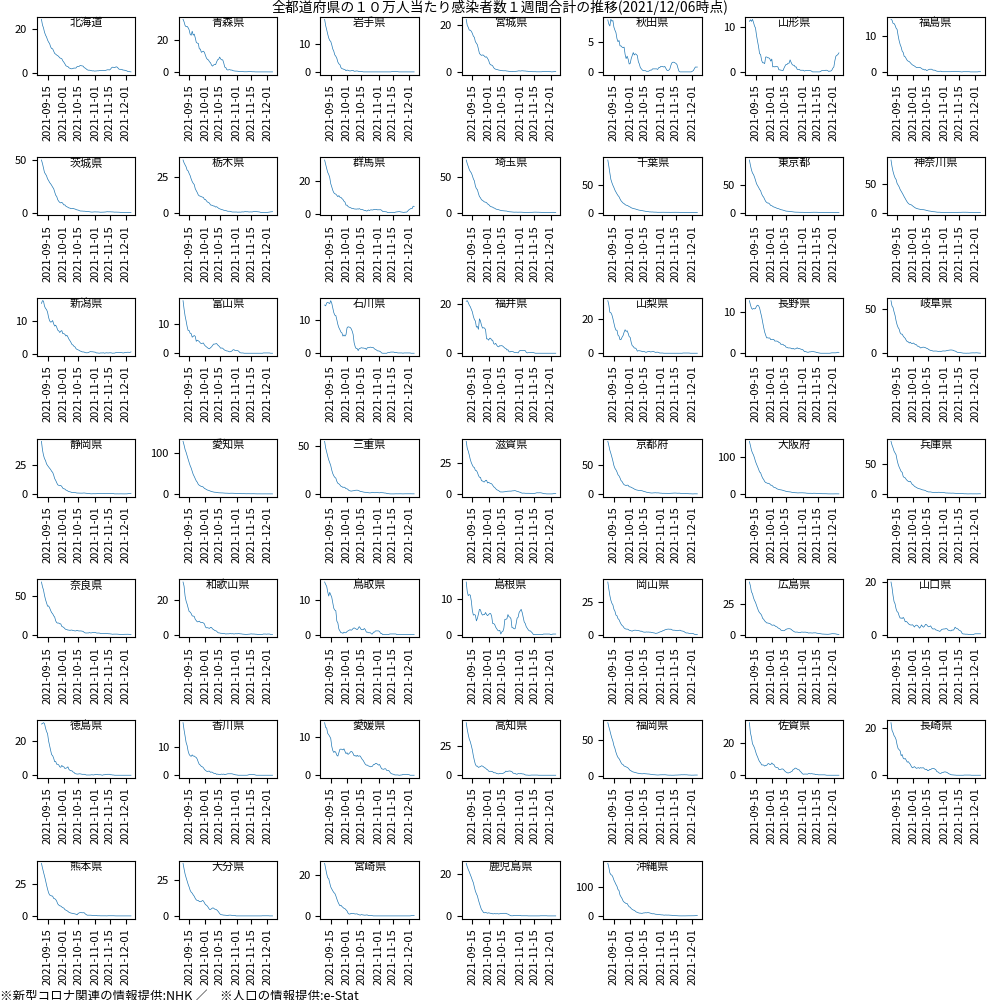

'\n    if prefs[p][2] == "":\n        text_date = dates.max()\n    else:\n        text_date = pd.to_datetime(prefs[p][2])\n    text_y = pref_recent.loc[(pref_recent["都道府県名"]==p) & (pref_recent["日付"]==text_date)]["10万人あたり感染者数1週間合計"]\n    plt.text(text_date,text_y,p,fontsize=8,va="center")\nplt.plot([dates.min(),dates.max()],[15,15],"-",lw=1.5,color="black")\nplt.text(dates.min(),15,"Stage3",ha="right",va="center",fontsize=9)\nplt.plot([dates.min(),dates.max()],[25,25],"-",lw=1.5,color="black")\nplt.text(dates.min(),25,"Stage4",ha="right",va="center",fontsize=9)\nplt.grid()\nplt.legend(bbox_to_anchor=(0, 1),loc=\'upper left\', fontsize=9)\nplt.ylabel("人数（人口１０万人あたり）")\n'

In [29]:
fig = plt.figure(figsize=(10,10),tight_layout=True)
fig.text(0.5,1,"全都道府県の１０万人当たり感染者数１週間合計の推移({}時点)".format(latest_date_str),va="top",ha="center")
fig.text(0,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=9)
dates = pref_recent["日付"].unique()
all_prefs = pref_recent["都道府県名"].unique()
for i,p in enumerate(all_prefs):
    plt.subplot(7,7,i+1) # (rows, columns, panel number)
    plt.title(p,fontsize=8,y=0.7)
    values = pref_recent.loc[pref_recent["都道府県名"]==p]["10万人あたり感染者数1週間合計"]
    if p in prefs:
        fmt=prefs[p][0]
        lw=prefs[p][1]
    else:
        fmt=":"
        lw=0.5
#    plt.plot_date(dates,values,fmt=fmt, lw=lw)
    plt.plot_date(dates,values,fmt="-", lw=0.5)
    plt.tick_params(axis="x",labelsize=8,rotation=90)
    plt.tick_params(axis="y",labelsize=8)
    

"""
    if prefs[p][2] == "":
        text_date = dates.max()
    else:
        text_date = pd.to_datetime(prefs[p][2])
    text_y = pref_recent.loc[(pref_recent["都道府県名"]==p) & (pref_recent["日付"]==text_date)]["10万人あたり感染者数1週間合計"]
    plt.text(text_date,text_y,p,fontsize=8,va="center")
plt.plot([dates.min(),dates.max()],[15,15],"-",lw=1.5,color="black")
plt.text(dates.min(),15,"Stage3",ha="right",va="center",fontsize=9)
plt.plot([dates.min(),dates.max()],[25,25],"-",lw=1.5,color="black")
plt.text(dates.min(),25,"Stage4",ha="right",va="center",fontsize=9)
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("人数（人口１０万人あたり）")
"""


## 感染速度

<IPython.core.display.Javascript object>


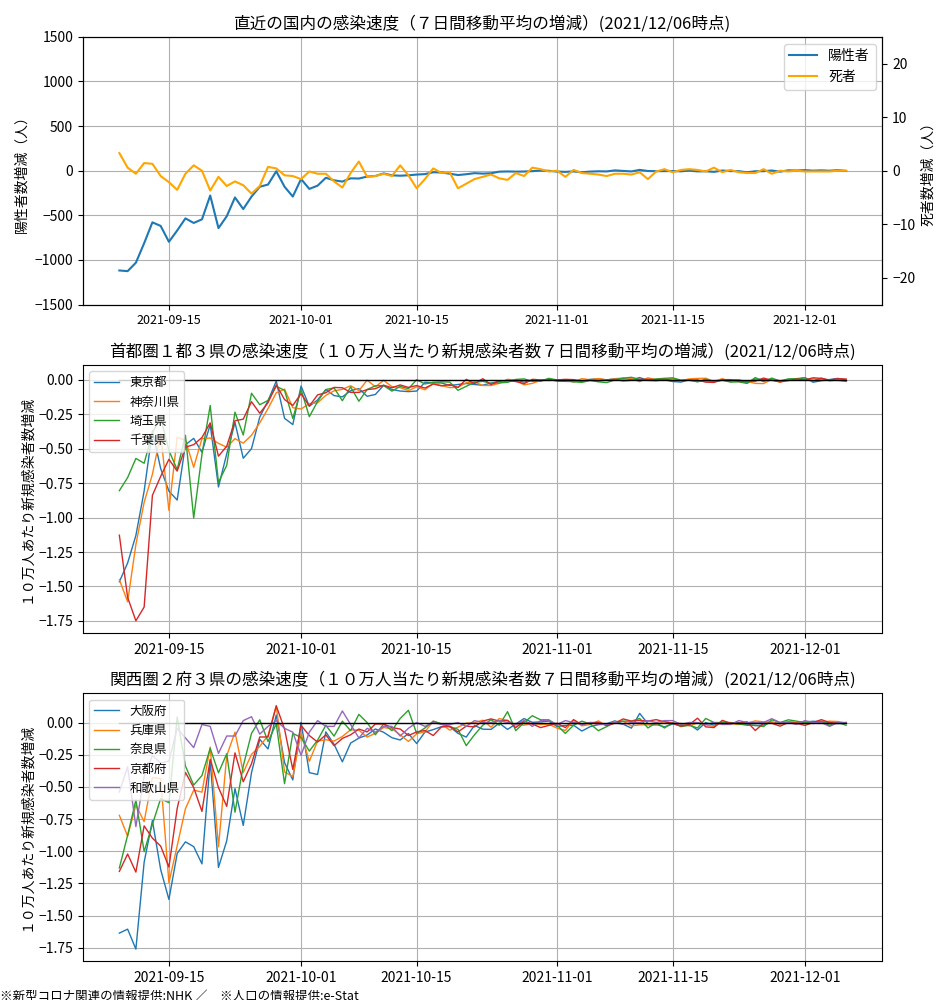

Text(0, 0, '※新型コロナ関連の情報提供:NHK ／\u3000※人口の情報提供:e-Stat')

In [30]:
fig = plt.figure(figsize=(9.5,10),tight_layout=True)
ax1 = plt.subplot(3,1,1) # (rows, columns, panel number)
plt.title("直近の国内の感染速度（７日間移動平均の増減）({}時点)".format(latest_date_str))
plt.plot_date(all_jp_recent["日付"],all_jp_recent["感染者数移動平均7増減"],label="陽性者",fmt="-")
plt.tick_params(axis="x",labelsize=9)
plt.ylabel("陽性者数増減（人）")
plt.grid()
plt.ylim(-1500,1500)
ax2 = plt.twinx()
ax2.plot_date(all_jp_recent["日付"],all_jp_recent["死者数移動平均7増減"],label="死者",fmt="-", color="orange")
plt.ylabel("死者数増減（人）")
plt.ylim(-25,25)
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2,l1+l2)

chart_data = pref_recent
dates = chart_data["日付"].unique()

ax1 = plt.subplot(3,1,2) # (rows, columns, panel number)
plt.title("首都圏１都３県の感染速度（１０万人当たり新規感染者数７日間移動平均の増減）({}時点)".format(latest_date_str))
target_p = ["東京都","神奈川県","埼玉県","千葉県"]
#stack_values = []
for p in target_p:
#    stack_values.append(chart_data.loc[chart_data["都道府県名"]==p]["10万人あたり感染者数移動平均7前日差"])
    values = chart_data.loc[chart_data["都道府県名"]==p]["10万人あたり感染者数移動平均7前日差"]
#    plt.fill_between(dates,values)
    plt.plot_date(dates,values,label=p, fmt="-", lw=1)
#plt.stackplot(dates, stack_values, labels=target_p)
plt.plot([dates.min(),dates.max()],[0,0],lw=1,color="black")
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("１０万人あたり新規感染者数増減")

ax1 = plt.subplot(3,1,3) # (rows, columns, panel number)
plt.title("関西圏２府３県の感染速度（１０万人当たり新規感染者数７日間移動平均の増減）({}時点)".format(latest_date_str))
target_p = ["大阪府","兵庫県","奈良県","京都府","和歌山県"]
for p in target_p:
    values = chart_data.loc[chart_data["都道府県名"]==p]["10万人あたり感染者数移動平均7前日差"]
    plt.plot_date(dates,values,label=p, fmt="-", lw=1)
plt.plot([dates.min(),dates.max()],[0,0],lw=1,color="black")
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("１０万人あたり新規感染者数増減")


fig.text(0,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=9)

In [31]:
#fig.savefig("out/covid-nhk-domestic-velocity-daily.png")

## 感染速度2(前週同曜日比)

<IPython.core.display.Javascript object>


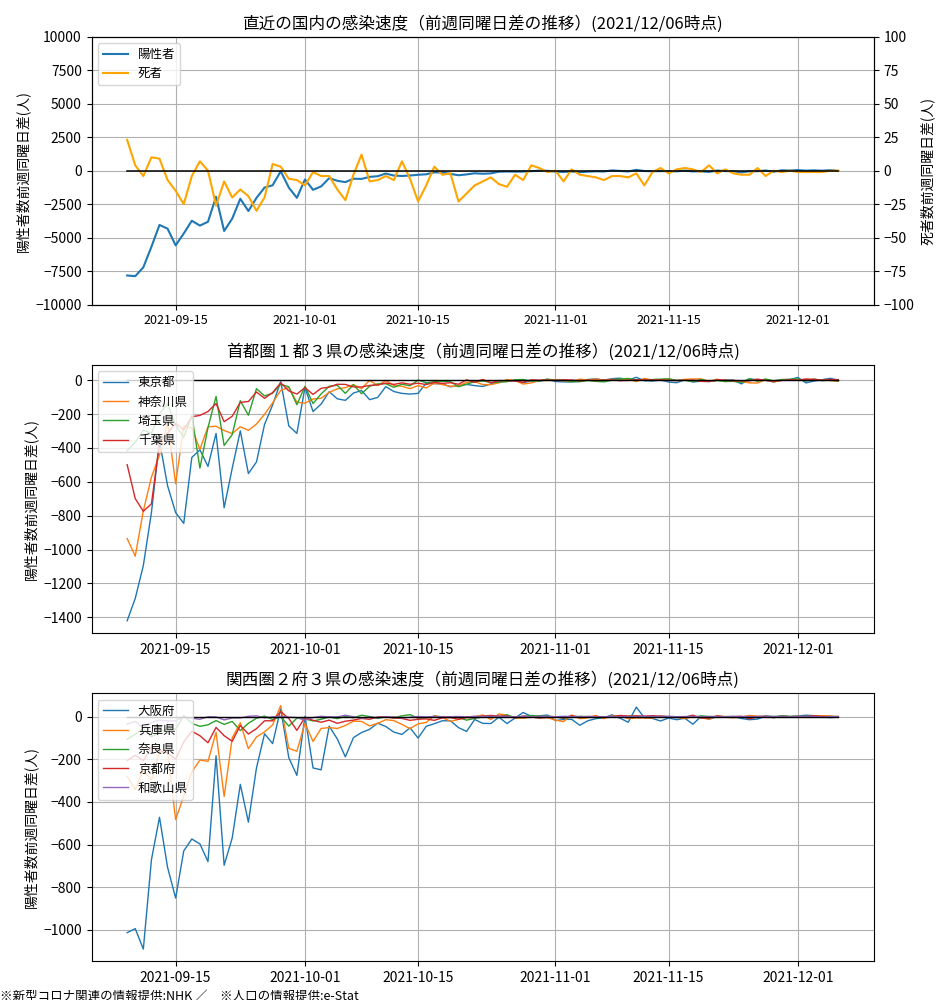

Text(0, 0, '※新型コロナ関連の情報提供:NHK ／\u3000※人口の情報提供:e-Stat')

In [32]:
fig = plt.figure(figsize=(9.5,10),tight_layout=True)
ax1 = plt.subplot(3,1,1) # (rows, columns, panel number)
plt.title("直近の国内の感染速度（前週同曜日差の推移）({}時点)".format(latest_date_str))
plt.plot_date(all_jp_recent["日付"],all_jp_recent["新規感染者数先週差"],label="陽性者",fmt="-")
#plt.plot_date(all_jp["日付"],all_jp["新規感染者数先週差"],label="陽性者",fmt="-")
plt.tick_params(axis="x",labelsize=9)
plt.ylabel("陽性者数前週同曜日差(人)")
plt.grid()
plt.ylim(-10000,10000)
ax2 = plt.twinx()
ax2.plot_date(all_jp_recent["日付"],all_jp_recent["死者数先週差"],label="死者",fmt="-", color="orange")
plt.ylabel("死者数前週同曜日差(人)")
plt.ylim(-100,100)
plt.plot([dates.min(),dates.max()],[0,0],lw=1.1,color="black")
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2,l1+l2,bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)

chart_data = pref_recent
dates = chart_data["日付"].unique()

ax1 = plt.subplot(3,1,2) # (rows, columns, panel number)
plt.title("首都圏１都３県の感染速度（前週同曜日差の推移）({}時点)".format(latest_date_str))
target_p = ["東京都","神奈川県","埼玉県","千葉県"]
#stack_values = []
for p in target_p:
    values = chart_data.loc[chart_data["都道府県名"]==p]["新規感染者数先週差"]
    plt.plot_date(dates,values,label=p, fmt="-", lw=1)
plt.plot([dates.min(),dates.max()],[0,0],lw=1,color="black")
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("陽性者数前週同曜日差(人)")


ax1 = plt.subplot(3,1,3) # (rows, columns, panel number)
plt.title("関西圏２府３県の感染速度（前週同曜日差の推移）({}時点)".format(latest_date_str))
target_p = ["大阪府","兵庫県","奈良県","京都府","和歌山県"]
for p in target_p:
    values = chart_data.loc[chart_data["都道府県名"]==p]["新規感染者数先週差"]
    plt.plot_date(dates,values,label=p, fmt="-", lw=1)
plt.plot([dates.min(),dates.max()],[0,0],lw=1,color="black")
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("陽性者数前週同曜日差(人)")


fig.text(0,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=9)

In [33]:
fig.savefig("out/covid-nhk-domestic-velocity-daily2.png")

<IPython.core.display.Javascript object>


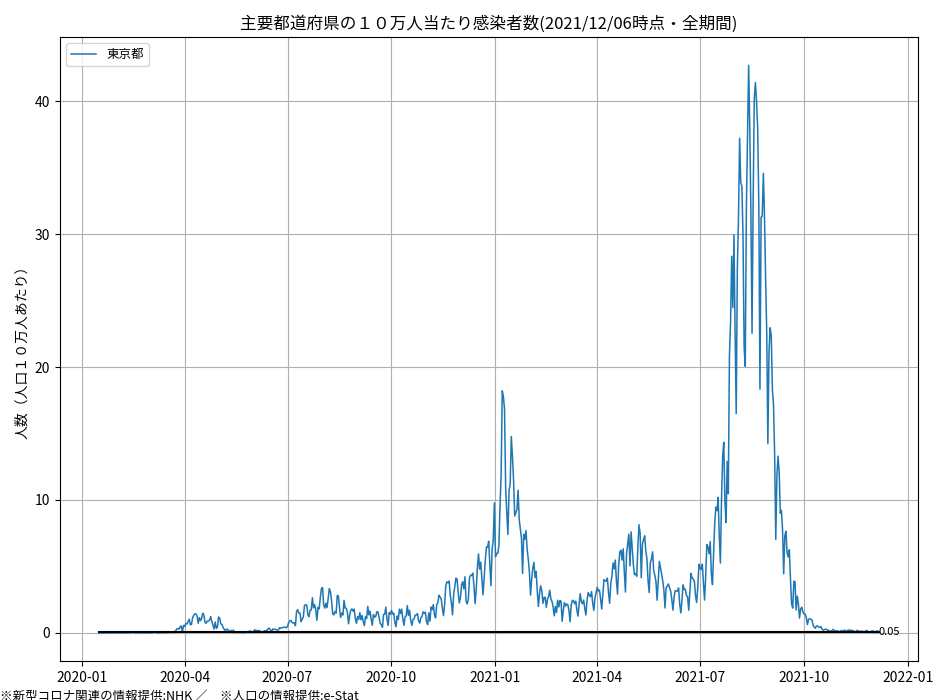

In [34]:
fig = plt.figure(figsize=(9.5,7))
plt.title("主要都道府県の１０万人当たり感染者数({}時点・全期間)".format(latest_date_str))
dates = pref["日付"].unique()
for p in prefs:
    if (p != "東京都") :
        continue
    values = pref.loc[pref["都道府県名"]==p]["10万人あたり感染者数"]
    plt.plot_date(dates,values,label=p, fmt=prefs[p][0], lw=prefs[p][1])
    if prefs[p][2] == "":
        text_date = dates.max()
    else:
        text_date = pd.to_datetime(prefs[p][2])
    text_y = pref.loc[(pref["都道府県名"]==p) & (pref["日付"]==text_date)]["10万人あたり感染者数"]
    plt.text(text_date,text_y,round(text_y.iloc[-1],2),fontsize=8,va="center")
    plt.plot([dates.min(),dates.max()],[text_y,text_y],"-",color="black")
plt.grid()
plt.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize=9)
plt.ylabel("人数（人口１０万人あたり）")
fig.text(0,0,"※新型コロナ関連の情報提供:NHK ／　※人口の情報提供:e-Stat",fontsize=9)

plt.tight_layout()